In [21]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/rafalpwiewiora/repos/NMpathAnalysis/nmpath")
import numpy as np
import pyemma
import mdtraj as md
from glob import glob
import math


from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print
from IPython.display import Markdown, display

In [2]:
def plot_its(lags, model, bayesian_model, ax, ylabel, dt=2.0E-4, confidence_interval=0.98):
    cout = 50 * (1.0 - confidence_interval)
    ax.fill_between(
        lags * dt,
        0.0,
        lags * dt,
        alpha=0.5, facecolor='grey')
    ax.plot(lags * dt, lags * dt, linewidth=2, color='black')
    for i in range(model.shape[1]):
        ax.fill_between(
            lags * dt,
            np.percentile(bayesian_model[:, :, i], cout, axis=1),
            np.percentile(bayesian_model[:, :, i], 100 - cout, axis=1),
            alpha=0.3, facecolor='C%d' % i)
        ax.plot(lags * dt, model[:, i], color='C%d' % i)
        ax.plot(lags * dt, np.median(bayesian_model[:, :, i], axis=1), ':o', color='C%d' % i)
    ax.set_xlabel(r'lagtime / $\mu$s')
    ax.set_ylabel(ylabel)
    
def get_lagtime_from_array(lags, lagtime, dt=2.0E-4):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def get_free_energy(tics, bins=100, use=[0, 1]):
    z, xedge, yedge = np.histogram2d(*tics[:, use].T, bins=bins)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    z = np.maximum(z, np.min(z[z > 0]))
    f = -np.log(z)
    f -= np.min(f)
    xx, yy = np.meshgrid(x, y)
    xy = np.array([xx.reshape(-1,), yy.reshape(-1,)]).T
    return dict(x=x, y=y, xx=xx, yy=yy, xy=xy, f=f.T, use=use)

def draw_free_energy(fe, ax, bw=False):
    if bw:
        cmap = mpl.cm.bone
        alpha=0.2
    else:
        cmap = mpl.cm.jet
        alpha=None
    levels = np.linspace(fe['f'].min(), fe['f'].max(), 100, endpoint=False)
    return ax.contourf(fe['x'], fe['y'], fe['f'], levels, cmap=cmap, alpha=alpha, vmin=0.0, vmax=np.max(fe['f']))

def get_metastable_distribution(model, state):
    pi = model.stationary_distribution.copy()
    for i, s in enumerate(model.metastable_sets):
        if i == state:
            continue
        pi[s] = 0.0
    pi /= pi.sum()
    return pi

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()

def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs, step=100):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if j%step == 0:
                if microstate in macrostates[0]:
                    rmsd_cluster0.append(rmsd[j])
                elif (len(macrostates) > 1) and microstate in macrostates[1]:
                    rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0, normed=True, bins=25, alpha=0.5,label="cluster-0", edgecolor="r")
        
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()

def rmsd_of_cluster(cluster, rmsd, dtraj):
    rmsd_list=[]
    for i,element in enumerate(rmsd):
        if dtraj[i] in cluster:
            rmsd_list.append(element)
    length = len(rmsd_list)
    
    if length == 0:
        return None

    return rmsd_list


color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']

/anaconda3/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.5, you have 2.5.2.
  .format(latest=latest, current=current), category=UserWarning)


In [3]:
dtrajs = np.load("../vamp_scoring/automatic_eigenvalue/trpcage/dtrajs_trpcage_lag10ns.npy")

In [15]:
msm1 = pyemma.msm.estimate_markov_model(list(dtrajs), lag=1, dt_traj='0.0002 us')

In [17]:
lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])

In [18]:
lag_to_use = [1]
lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]
range_per_lag = [[200,370]]

### Lag-time: 0.2ns

#### t_values:

t_cut: 40.00ns, t_min: 54.88ns, t_max: 1.73e+03ns, tAB: 0.00ns
t_cut: 42.20ns, t_min: 54.88ns, t_max: 1.73e+03ns, tAB: 0.00ns
t_cut: 44.40ns, t_min: 54.88ns, t_max: 1.73e+03ns, tAB: 0.00ns
t_cut: 46.60ns, t_min: 54.88ns, t_max: 1.73e+03ns, tAB: 0.00ns
t_cut: 48.80ns, t_min: 54.88ns, t_max: 1.73e+03ns, tAB: 0.00ns
t_cut: 51.00ns, t_min: 54.88ns, t_max: 1.73e+03ns, tAB: 0.00ns
t_cut: 53.20ns, t_min: 54.88ns, t_max: 1.73e+03ns, tAB: 0.00ns
t_cut: 55.40ns, t_min: 57.55ns, t_max: 1.73e+03ns, tAB: 164.13ns
t_cut: 57.60ns, t_min: 60.50ns, t_max: 1.73e+03ns, tAB: 164.13ns
t_cut: 59.80ns, t_min: 60.50ns, t_max: 1.73e+03ns, tAB: 164.13ns
t_cut: 62.00ns, t_min: 62.28ns, t_max: 1.73e+03ns, tAB: 164.13ns
t_cut: 64.20ns, t_min: 65.76ns, t_max: 1.73e+03ns, tAB: 461.88ns
t_cut: 66.40ns, t_min: 67.10ns, t_max: 1.73e+03ns, tAB: 413.18ns
t_cut: 68.60ns, t_min: 68.79ns, t_max: 1.73e+03ns, tAB: 553.55ns
t_cut: 70.80ns, t_min: 72.68ns, t_max: 1.73e+03ns, tAB: 553.55ns


#### t_AB plots:

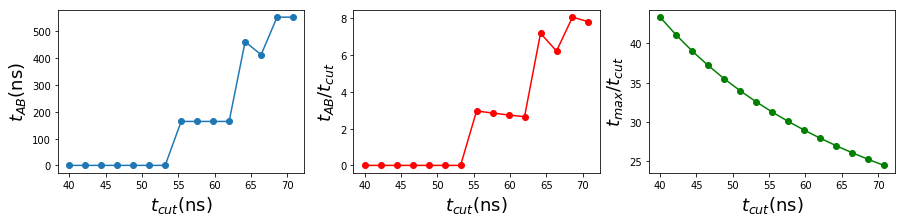

In [24]:
K = msm1.P
dt = 0.2
#---------------------
printmd("### Lag-time: "+str(dt)+"ns")

t_min_list=[]
t_max_list=[]
t_AB_list=[]

big_clusters_list = []

# t_cut range
min_ = range_per_lag[0][0]
max_ = range_per_lag[0][1]
interval = (max_ - min_)//15 
t_cut_values =  [min_+i for i in range(0,max_- min_,interval)][0:15]


fig_n_cols = 3
fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

printmd("#### t_values:")

for ii, t_cut in enumerate(t_cut_values):

    big_clusters=[]
    big_clusters_index =[]

    # clustering
    #clusters, t_min, t_max, clustered_tmatrix = kinetic_clustering_from_tmatrix(K, t_cut=t_cut, verbose=False)
    clusters, t_min, t_max = kinetic_clustering2_from_tmatrix(K, t_cut=t_cut, verbose=False)


    t_min_list.append(t_min)
    t_max_list.append(t_max)

    for i, cluster_i in enumerate(clusters):
        if len(cluster_i) > 1:
            big_clusters.append(cluster_i)
            big_clusters_index.append(i)

    n_big = len(big_clusters)

    macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
    #macrostates_list.append([ clusters[macrostates[i]] for i in range(len(macrostates))])
    big_clusters_list.append(big_clusters)

    if n_big > 1:
        #tAB = markov_commute_time(clustered_tmatrix,[macrostates[0]],[macrostates[1]] )
        tAB = markov_commute_time(K,[macrostates[0]],[macrostates[1]] )
    else:
        tAB = 0.0
    t_AB_list.append(tAB)

    print("t_cut: {:.2f}ns, t_min: {:.2f}ns, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))

#     plt.subplot(fig_n_rows, fig_n_cols, ii+1)
#     pyemma.plots.plot_free_energy(*tica.T)
#     plt.scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
#     plt.annotate("t_cut: {:.2f}ns".format(t_cut*dt), xy=(-0.8,-4))

#     colors = ['red','blue','green','black','orange'] + color_sequence

#     for i, cluster_i in enumerate(big_clusters):
#         cluster_i_tica_xy = []
#         for index in cluster_i:
#             cluster_i_tica_xy.append(cluster.clustercenters[index])
#         cluster_i_tica_xy = np.array(cluster_i_tica_xy)
#         plt.scatter(*cluster_i_tica_xy.T, marker='o', c=colors[i], s=30, label='cluster-'+str(i))

#     plt.legend(loc='upper left')
#     plt.xlabel('TIC 1 / a.u.')
#     plt.ylabel('TIC 2 / a.u.')
        
# printmd("#### Observed clusters vs t_cut")
# plt.show()

printmd("#### t_AB plots:")
plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)

In [25]:
big_clusters_list

[[[23, 56, 37]],
 [[23, 56, 37]],
 [[23, 56, 37]],
 [[23, 56, 37]],
 [[23, 56, 37]],
 [[23, 56, 37]],
 [[23, 56, 37]],
 [[4, 36], [23, 56, 37]],
 [[4, 36], [23, 56, 37], [30, 86]],
 [[4, 36], [23, 56, 37], [30, 86]],
 [[4, 36], [23, 56, 37], [30, 86], [90, 92]],
 [[4, 36], [23, 56, 37], [30, 86, 90, 92]],
 [[4, 36, 51], [23, 56, 37], [30, 86, 90, 92]],
 [[4, 36, 51], [23, 56, 37], [26, 39], [30, 86, 90, 92]],
 [[0, 26, 39], [4, 36, 51], [23, 56, 37], [30, 86, 90, 92]]]

In [29]:
#Selection of the t_cut
macrostates = biggest_clusters_indexes(big_clusters_list[7], n_pick=2)

# Folded and unfolded definition
stateA = big_clusters_list[7][macrostates[0]]
stateB = big_clusters_list[7][macrostates[1]]

# rmsdA = rmsd_of_cluster(stateA, rmsd, dtrajs[0])
# rmsdB = rmsd_of_cluster(stateB, rmsd, dtrajs[0])

# #stateA is always the unfolded state
# if rmsdB > rmsdA:
#     stateA, stateB = stateB, stateA

# print("RMSD folded:   ", rmsdB )
# print("RMSD unfolded: ", rmsdA )

In [30]:
stateA # folded

[23, 56, 37]

In [31]:
stateB # unfolded

[4, 36]

In [34]:
lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

In [35]:
dt = 0.0002 # in micro-sec

lag_to_use = lags[0:16:2]

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

In [42]:
dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

for i, lag in enumerate(lag_to_use):
    
    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
#     nm_model_hist10ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
#     nm_model_hist20ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=100)
#     nm_model_hist50ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=250)
#     nm_model_hist100ns = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
#     nm_kinetics = nm_model.mfpts()
#     nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
#     nm_model_hist20ns_kinetics = nm_model_hist20ns.mfpts()
#     nm_model_hist50ns_kinetics = nm_model_hist50ns.mfpts()
#     nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
#     nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
#     nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
#     nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
#     nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
#     nm_hist20ns_mfptsAB.append(nm_model_hist20ns_kinetics['mfptAB']*dt)
#     nm_hist20ns_mfptsBA.append(nm_model_hist20ns_kinetics['mfptBA']*dt)
    
#     nm_hist50ns_mfptsAB.append(nm_model_hist50ns_kinetics['mfptAB']*dt)
#     nm_hist50ns_mfptsBA.append(nm_model_hist50ns_kinetics['mfptBA']*dt)
    
#     nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
#     nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 26/26
Number of A->B/B->A  events: 18/18
Number of A->B/B->A  events: 12/12
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 9/9
Number of A->B/B->A  events: 9/9
Number of A->B/B->A  events: 8/8
Number of A->B/B->A  events: 7/7


#### Is there an inflection point?:

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2966: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


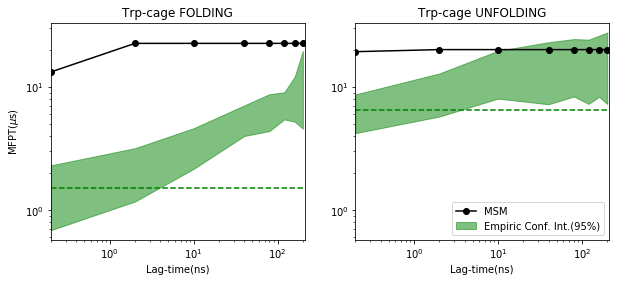

In [43]:
lag_to_use_ns = np.array(lag_to_use) * 0.2

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

printmd("#### Is there an inflection point?:")

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empiric Conf. Int.(95%)" )


# ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM(hist=10ns)", c='b')
# ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM(hist=100ns)", c='b')
# ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM(full history)", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
#ax1.plot(lag_to_use_ns, lag_to_use_ns/nm_model.popA/1000, c='purple')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Trp-cage FOLDING")
ax1.set_xlabel("Lag-time(ns)")
ax1.set_ylabel("MFPT($\mu$s)")
ax1.set_xlim(0,210)
#plt.legend(loc='upper left')

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empiric Conf. Int.(95%)" )

# ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="haMSM(hist=10ns)", c='b')
# ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", label="haMSM(hist=100ns)", c='b')
# ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="haMSM(full history)", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")
#ax2.plot(lag_to_use_ns, lag_to_use_ns/nm_model.popB/1000, color='purple')


ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Trp-cage UNFOLDING")
ax2.set_xlabel("Lag-time(ns)")
ax2.set_xlim(0,210)
plt.legend(loc='lower right')
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [44]:
pwd

'/Users/rafalpwiewiora/repos/msm-mfpt/models3_10_interm_states'